# REINFORCE on V0 with custom rewards

/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:593: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` i

Episode 50	Average Reward: 44.30
Episode 100	Average Reward: 130.72

Environment solved in 140 episodes with average reward 195.77 over the last 30.00 episodes.


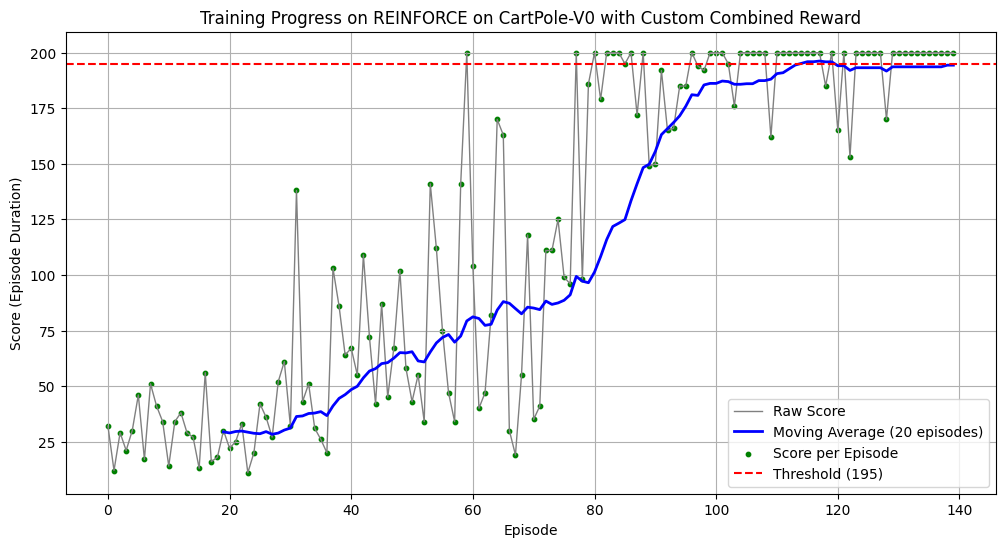

Test Scores Summary:
count    100.0
mean     200.0
std        0.0
min      200.0
25%      200.0
50%      200.0
75%      200.0
max      200.0
Name: Score, dtype: float64
Success Count (Score >= 195):
Success
True    100
Name: count, dtype: int64


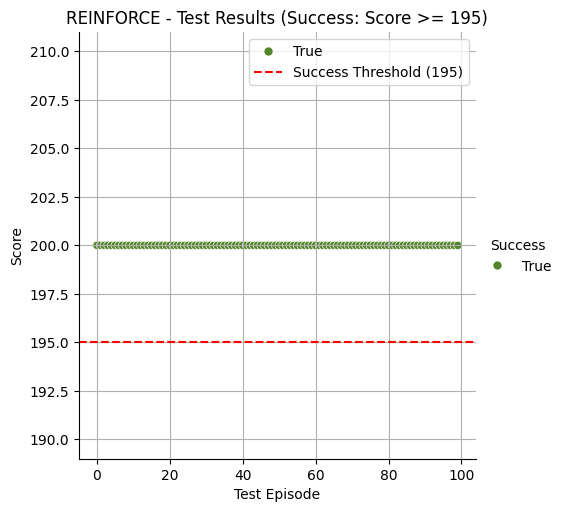

In [16]:
# Import necessary libraries
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import gym, random
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns


# Set the random seed for reproducibility
seed = 3
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

# Create the environment
env = gym.make('CartPole-v0')
env.seed(seed)

# Get state and action dimensions
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

# Get thresholds from environment constraints
theta_threshold = (env.observation_space.high[2]) / 2 - 0.001  # Pole angle
x_threshold = env.observation_space.high[0]  # Cart position

# Define the policy network
class PolicyNetwork(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_size=128):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, action_dim)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        probs = self.softmax(x)
        return probs

# Instantiate the policy network
policy_net = PolicyNetwork(state_dim, action_dim, hidden_size=128)

# Set the optimizer
learning_rate = 0.003
optimizer = optim.Adam(policy_net.parameters(), lr=learning_rate)

# Training parameters
gamma = 0.95
num_episodes = 500
max_steps = 200

# For logging
episode_rewards = []

for episode in range(1, num_episodes + 1):
    env.seed(episode)
    state = env.reset()
    env.seed(episode)

    state = torch.from_numpy(state).float()
    rewards = []
    log_probs = []

    for t in range(max_steps):
        # Get action probabilities from the policy network
        probs = policy_net(state)
        # Sample an action from the probability distribution
        m = torch.distributions.Categorical(probs)
        action = m.sample()
        log_prob = m.log_prob(action)
        # Step the environment
        next_state, _, done, _ = env.step(action.item())

        # Extract state variables
        x = abs(next_state[0])  # Cart position (absolute value)
        theta = abs(next_state[2])  # Pole angle (absolute value)

        # Compute custom rewards
        weight1=0.15
        cart = np.exp((x_threshold - x) / x_threshold) - 0.999  # Cart position reward
        angle = np.exp((theta_threshold - theta) / theta_threshold) - 0.999  # Pole angle reward
        reward = (weight1 * cart) + ((1-weight1) * angle)  # Combined reward

        next_state = torch.from_numpy(next_state).float()
        # Save reward and log probability
        rewards.append(reward)
        log_probs.append(log_prob)
        # Update state
        state = next_state
        if done:
            break

    # Compute the cumulative rewards (returns) for the episode
    returns = []
    G = 0
    for r in reversed(rewards):
        G = r + gamma * G
        returns.insert(0, G)
    returns = torch.tensor(returns)
    # Normalize returns for better convergence
    returns = (returns - returns.mean()) / (returns.std() + 1e-9)
    # Compute policy gradient loss
    loss = []
    for log_prob, Gt in zip(log_probs, returns):
        loss.append(-log_prob * Gt)
    loss = torch.stack(loss).sum()
    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    # Log episode reward
    episode_rewards.append(t + 1)
    # Print progress every 50 episodes
    if episode % 50 == 0:
        avg_reward = np.mean(episode_rewards[-50:])
        print(f"Episode {episode}\tAverage Reward: {avg_reward:.2f}")

    convergence_criteria = 30
    # Check for convergence
    if episode >= convergence_criteria:
        avg_reward = np.mean(episode_rewards[-convergence_criteria:])
        if avg_reward >= 195.0:
            print(f"\nEnvironment solved in {episode} episodes with average reward {avg_reward:.2f} over the last {convergence_criteria:.2f} episodes.")
            break

# Close the environment
env.close()

# Calculate a moving average with a window size of 50
def plot_train(name, score_array, window_size = 50):

    if len(score_array) >= window_size:
        moving_avg = np.convolve(score_array, np.ones(window_size) / window_size, mode='valid')
    else:
        moving_avg = score_array  # If not enough data points, use the raw scores

    # Plot the raw scores and the moving average
    plt.figure(figsize=(12, 6))
    plt.plot(score_array, color='gray', linewidth=1, label='Raw Score')
    plt.plot(range(window_size - 1, len(score_array)), moving_avg, color='blue', linewidth=2, label=f'Moving Average ({window_size} episodes)')
    plt.scatter(range(len(score_array)), score_array, color='green', s=10, label='Score per Episode')
    plt.axhline(y=195, color='red', linestyle='--', label='Threshold (195)')

    # Labels and title
    plt.xlabel('Episode')
    plt.ylabel('Score (Episode Duration)')
    plt.title('Training Progress on %s with Custom Combined Reward'%(name))
    plt.legend()
    plt.grid(True)
    plt.show()

# # Convert 'episode_rewards' to a NumPy array for easy manipulation
score_array = np.array(episode_rewards)

plot_train('REINFORCE on CartPole-V0', score_array, 20)


# # Calculate a moving average with a window size of 50
# window_size = 50
# if len(score_array) >= window_size:
#     moving_avg = np.convolve(score_array, np.ones(window_size) / window_size, mode='valid')
# else:
#     moving_avg = score_array  # If not enough data points, use the raw scores

# # Plot the raw scores and the moving average
# plt.figure(figsize=(12, 6))
# plt.plot(score_array, color='gray', linewidth=1, label='Raw Score')
# plt.plot(range(window_size - 1, len(score_array)), moving_avg, color='blue', linewidth=2, label=f'Moving Average ({window_size} episodes)')
# plt.scatter(range(len(score_array)), score_array, color='green', s=10, label='Score per Episode')
# plt.axhline(y=195, color='red', linestyle='--', label='Threshold (195)')

# # Labels and title
# plt.xlabel('Episode')
# plt.ylabel('Score (Episode Duration)')
# plt.title('Training Progress of Policy Gradient on CartPole with Custom Combined Reward')
# plt.legend()
# plt.grid(True)
# plt.show()


# Function to sample action based on the trained policy
def test_policy_sample(state, policy_net):
    state_tensor = torch.FloatTensor(state).unsqueeze(0)
    with torch.no_grad():
        action_probs = policy_net(state_tensor)
        dist = torch.distributions.Categorical(action_probs)
        action = dist.sample().item()
    return action

# Function to test the agent's performance in one episode
def test_agent_base_rl(seed, print_reward=False):
    env = gym.make('CartPole-v0')
    env.seed(seed)
    state = env.reset()
    env.seed(seed)

    rewards = []

    for t in range(200):
        action = test_policy_sample(state, policy_net)
        state, reward, terminated, truncated = env.step(action)
        done = terminated or truncated
        rewards.append(reward)
        if done:
            total_reward = sum(rewards)
            if print_reward:
                print(f"Episode {seed}, Total Reward: {total_reward}")
            return total_reward
    env.close()

# Function to test the agent across multiple episodes and visualize the results
def plot_test_results_base_rl(method='Base RL', total_tests=100):
    seed = 3
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

    test_scores = []
    for i in range(total_tests):
        test_scores.append(test_agent_base_rl(i, print_reward=False))

    # Print summary statistics
    print("Test Scores Summary:")
    test_df = pd.DataFrame({'Test': range(total_tests), 'Score': test_scores})
    test_df['Success'] = test_df['Score'] >= 195
    print(test_df['Score'].describe())

    # Count successes
    success_count = test_df['Success'].value_counts()
    print("Success Count (Score >= 195):")
    print(success_count)

    # Visualization
    colors = {True: "#54852A", False: "#E33079"}
    sns.relplot(data=test_df, x="Test", y="Score", hue="Success", palette=colors)
    plt.axhline(y=195, color='red', linestyle='--', label='Success Threshold (195)')
    plt.title(f"{method} - Test Results (Success: Score >= 195)")
    plt.xlabel("Test Episode")
    plt.ylabel("Score")
    plt.legend()
    plt.grid(True)
    plt.show()

# seed2, weight0.14, epoch169, mu199.73, success99%
# seed3, weight0.14, epoch166, mu200, success100% - 199.796000, 498
# seed17, weigh0.14, epoch186, mu200, success100 - 200, 100
## seed3, weight0.15, epoch144, mu200, success100% - 199.396000, 496
## seed3, weight0.155, epoch192, mu200, success100% - 199.954000, 499

# Run the testing and plotting function
plot_test_results_base_rl(method="REINFORCE", total_tests=100)

# REINFORCE on V0 without custom rewards

/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:593: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` i

Episode 50	Average Reward: 22.28
Episode 100	Average Reward: 48.68
Episode 150	Average Reward: 150.74
Episode 200	Average Reward: 194.48

Environment solved in 202 episodes with average reward 196.23 over the last 30.00 episodes.


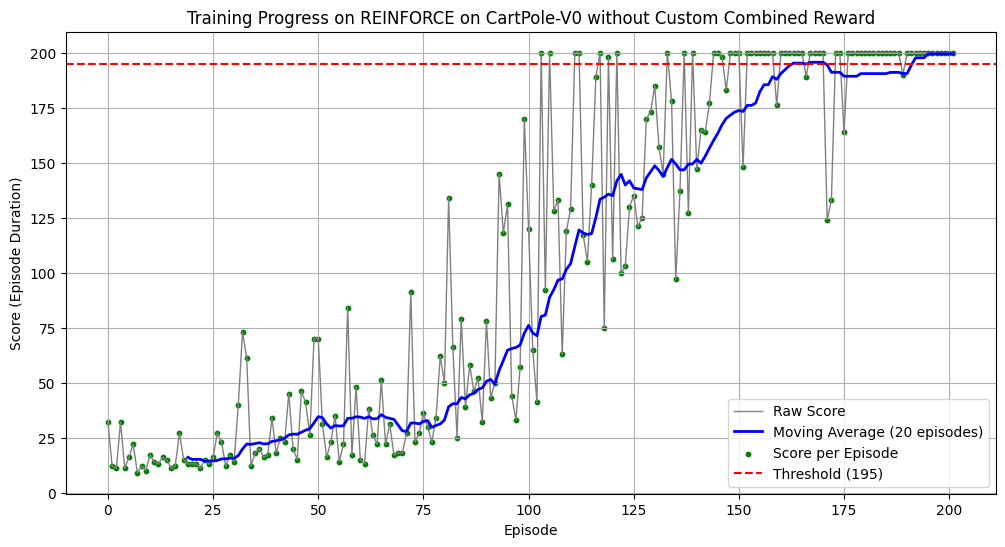

/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:593: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


Test Scores Summary:
count    100.000000
mean     195.420000
std       21.358498
min       56.000000
25%      200.000000
50%      200.000000
75%      200.000000
max      200.000000
Name: Score, dtype: float64
Success Count (Score >= 195):
Success
True     93
False     7
Name: count, dtype: int64


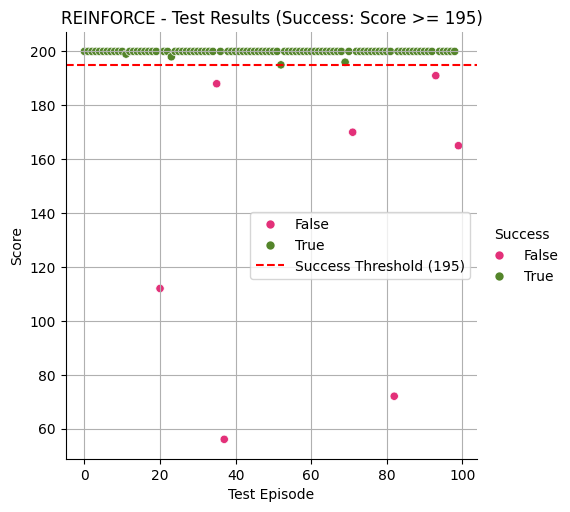

In [1]:
# Import necessary libraries
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import gym, random
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns


# Set the random seed for reproducibility
seed = 3
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

# Create the environment
env = gym.make('CartPole-v0')
env.seed(seed)

# Get state and action dimensions
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

# Get thresholds from environment constraints
theta_threshold = (env.observation_space.high[2]) / 2 - 0.001  # Pole angle
x_threshold = env.observation_space.high[0]  # Cart position

# Define the policy network
class PolicyNetwork(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_size=128):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, action_dim)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        probs = self.softmax(x)
        return probs

# Instantiate the policy network
policy_net = PolicyNetwork(state_dim, action_dim, hidden_size=128)

# Set the optimizer
learning_rate = 0.003
optimizer = optim.Adam(policy_net.parameters(), lr=learning_rate)

# Training parameters
gamma = 0.95
num_episodes = 500
max_steps = 200

# For logging
episode_rewards = []

for episode in range(1, num_episodes + 1):
    env.seed(episode)
    state = env.reset()
    env.seed(episode)

    state = torch.from_numpy(state).float()
    rewards = []
    log_probs = []

    for t in range(max_steps):
        # Get action probabilities from the policy network
        probs = policy_net(state)
        # Sample an action from the probability distribution
        m = torch.distributions.Categorical(probs)
        action = m.sample()
        log_prob = m.log_prob(action)
        # Step the environment
        next_state, r, done, _ = env.step(action.item())

#         # Extract state variables
#         x = abs(next_state[0])  # Cart position (absolute value)
#         theta = abs(next_state[2])  # Pole angle (absolute value)

#         # Compute custom rewards
#         weight1=0.15
#         cart = np.exp((x_threshold - x) / x_threshold) - 0.999  # Cart position reward
#         angle = np.exp((theta_threshold - theta) / theta_threshold) - 0.999  # Pole angle reward
#         reward = (weight1 * cart) + ((1-weight1) * angle)  # Combined reward

        next_state = torch.from_numpy(next_state).float()
        # Save reward and log probability
        # rewards.append(reward)
        rewards.append(r)

        log_probs.append(log_prob)
        # Update state
        state = next_state
        if done:
            break

    # Compute the cumulative rewards (returns) for the episode
    returns = []
    G = 0
    for r in reversed(rewards):
        G = r + gamma * G
        returns.insert(0, G)
    returns = torch.tensor(returns)
    # Normalize returns for better convergence
    returns = (returns - returns.mean()) / (returns.std() + 1e-9)
    # Compute policy gradient loss
    loss = []
    for log_prob, Gt in zip(log_probs, returns):
        loss.append(-log_prob * Gt)
    loss = torch.stack(loss).sum()
    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    # Log episode reward
    episode_rewards.append(t + 1)
    # Print progress every 50 episodes
    if episode % 50 == 0:
        avg_reward = np.mean(episode_rewards[-50:])
        print(f"Episode {episode}\tAverage Reward: {avg_reward:.2f}")

    convergence_criteria = 30
    # Check for convergence
    if episode >= convergence_criteria:
        avg_reward = np.mean(episode_rewards[-convergence_criteria:])
        if avg_reward >= 195.0:
            print(f"\nEnvironment solved in {episode} episodes with average reward {avg_reward:.2f} over the last {convergence_criteria:.2f} episodes.")
            break

# Close the environment
env.close()

# Calculate a moving average with a window size of 50
def plot_train(name, score_array, window_size = 50):

    if len(score_array) >= window_size:
        moving_avg = np.convolve(score_array, np.ones(window_size) / window_size, mode='valid')
    else:
        moving_avg = score_array  # If not enough data points, use the raw scores

    # Plot the raw scores and the moving average
    plt.figure(figsize=(12, 6))
    plt.plot(score_array, color='gray', linewidth=1, label='Raw Score')
    plt.plot(range(window_size - 1, len(score_array)), moving_avg, color='blue', linewidth=2, label=f'Moving Average ({window_size} episodes)')
    plt.scatter(range(len(score_array)), score_array, color='green', s=10, label='Score per Episode')
    plt.axhline(y=195, color='red', linestyle='--', label='Threshold (195)')

    # Labels and title
    plt.xlabel('Episode')
    plt.ylabel('Score (Episode Duration)')
    plt.title('Training Progress on %s without Custom Combined Reward'%(name))
    plt.legend()
    plt.grid(True)
    plt.show()

# # Convert 'episode_rewards' to a NumPy array for easy manipulation
score_array = np.array(episode_rewards)

plot_train('REINFORCE on CartPole-V0', score_array, 20)



# Function to sample action based on the trained policy
def test_policy_sample(state, policy_net):
    state_tensor = torch.FloatTensor(state).unsqueeze(0)
    with torch.no_grad():
        action_probs = policy_net(state_tensor)
        dist = torch.distributions.Categorical(action_probs)
        action = dist.sample().item()
    return action

# Function to test the agent's performance in one episode
def test_agent_base_rl(seed, print_reward=False):
    env = gym.make('CartPole-v0')
    env.seed(seed)
    state = env.reset()
    env.seed(seed)

    rewards = []

    for t in range(200):
        action = test_policy_sample(state, policy_net)
        state, reward, terminated, truncated = env.step(action)
        done = terminated or truncated
        rewards.append(reward)
        if done:
            total_reward = sum(rewards)
            if print_reward:
                print(f"Episode {seed}, Total Reward: {total_reward}")
            return total_reward
    env.close()

# Function to test the agent across multiple episodes and visualize the results
def plot_test_results_base_rl(method='Base RL', total_tests=100):
    seed = 3
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

    test_scores = []
    for i in range(total_tests):
        test_scores.append(test_agent_base_rl(i, print_reward=False))

    # Print summary statistics
    print("Test Scores Summary:")
    test_df = pd.DataFrame({'Test': range(total_tests), 'Score': test_scores})
    test_df['Success'] = test_df['Score'] >= 195
    print(test_df['Score'].describe())

    # Count successes
    success_count = test_df['Success'].value_counts()
    print("Success Count (Score >= 195):")
    print(success_count)

    # Visualization
    colors = {True: "#54852A", False: "#E33079"}
    sns.relplot(data=test_df, x="Test", y="Score", hue="Success", palette=colors)
    plt.axhline(y=195, color='red', linestyle='--', label='Success Threshold (195)')
    plt.title(f"{method} - Test Results (Success: Score >= 195)")
    plt.xlabel("Test Episode")
    plt.ylabel("Score")
    plt.legend()
    plt.grid(True)
    plt.show()

# seed2, weight0.14, epoch169, mu199.73, success99%
# seed3, weight0.14, epoch166, mu200, success100% - 199.796000, 498
# seed17, weigh0.14, epoch186, mu200, success100 - 200, 100
## seed3, weight0.15, epoch144, mu200, success100% - 199.396000, 496
## seed3, weight0.155, epoch192, mu200, success100% - 199.954000, 499

# Run the testing and plotting function
plot_test_results_base_rl(method="REINFORCE", total_tests=100)

# REINFORCE on V1 with custom rewards

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym

Episode 50	Average Reward: 44.30
Episode 100	Average Reward: 147.66
Episode 150	Average Reward: 327.04
Episode 200	Average Reward: 387.52

Environment solved in 238 episodes with average reward 496.45 over the last 20.00 episodes.


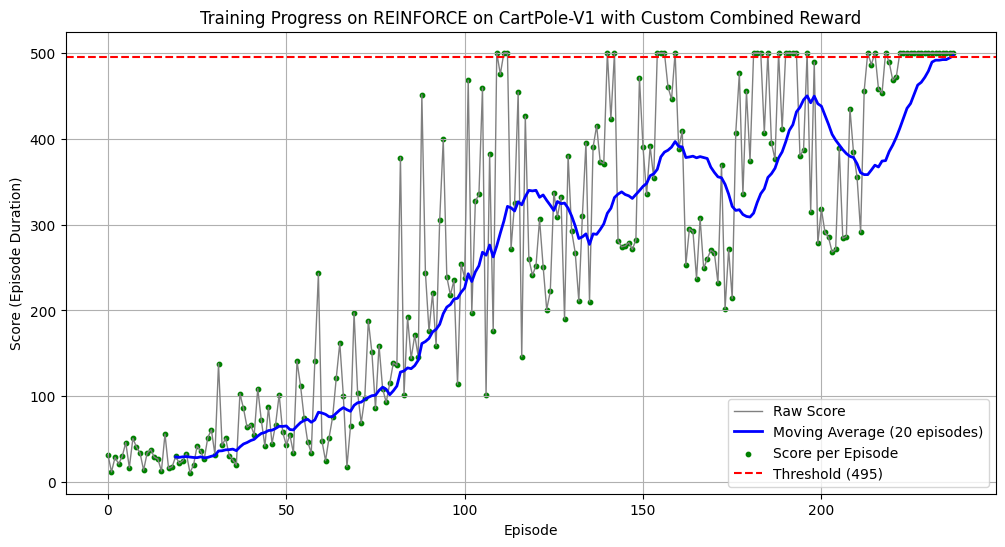

[500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 402.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0]
count    100.00
mean     499.02
std        9.80
min      402.00
25%      500.00
50%      500.00
75%      500.00
max      500.00
Name: score, dtype: float64
success
True     99
False     1
Name: count, dtype: int64


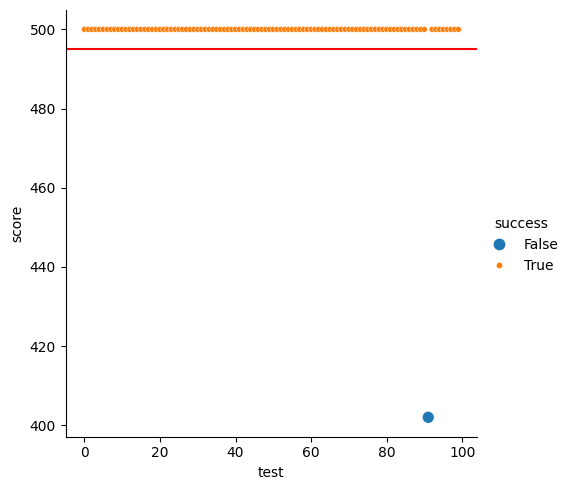

/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:593: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` i

[200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0]
Test Scores Summary:
count    100.0
mean     200.0
std        0.0
min      200.0
25%      200.0
50%      200.0
75%      200.0
max      200.0
Name: Score, dtype: float64
Success Count (Score >= 195):
Success
True    100
Name: count, dtype: int64


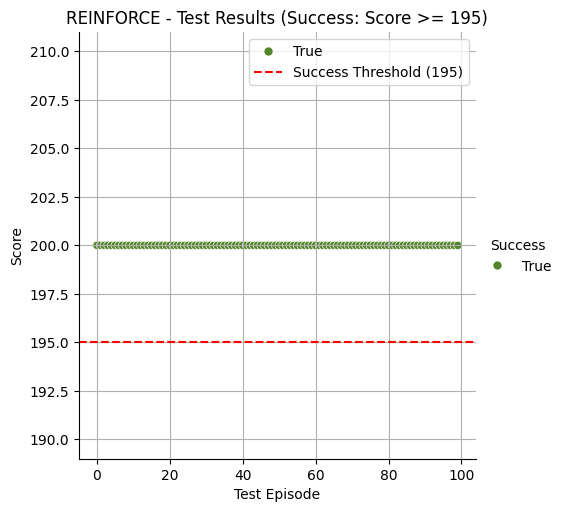

In [14]:
# Import necessary libraries
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import gym, random
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns


# Set the random seed for reproducibility
seed = 3
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

# Create the environment
env = gym.make('CartPole-v1')
env.seed(seed)

# Get state and action dimensions
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

# Get thresholds from environment constraints
theta_threshold = (env.observation_space.high[2]) / 2 - 0.001  # Pole angle
x_threshold = env.observation_space.high[0]  # Cart position

# Define the policy network
class PolicyNetwork(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_size=128):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, action_dim)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        probs = self.softmax(x)
        return probs

# Instantiate the policy network
policy_net = PolicyNetwork(state_dim, action_dim, hidden_size=128)

# Set the optimizer
learning_rate = 0.003
optimizer = optim.Adam(policy_net.parameters(), lr=learning_rate)

# Training parameters
gamma = 0.95
num_episodes = 500
max_steps = 500

# For logging
episode_rewards = []

for episode in range(1, num_episodes + 1):
    env.seed(episode)
    state = env.reset()
    env.seed(episode)

    state = torch.from_numpy(state).float()
    rewards = []
    log_probs = []

    for t in range(max_steps):
        # Get action probabilities from the policy network
        probs = policy_net(state)
        # Sample an action from the probability distribution
        m = torch.distributions.Categorical(probs)
        action = m.sample()
        log_prob = m.log_prob(action)
        # Step the environment
        next_state, _, done, _ = env.step(action.item())

        # Extract state variables
        x = abs(next_state[0])  # Cart position (absolute value)
        theta = abs(next_state[2])  # Pole angle (absolute value)

        # Compute custom rewards
        weight1=0.15
        cart = np.exp((x_threshold - x) / x_threshold) - 0.999  # Cart position reward
        angle = np.exp((theta_threshold - theta) / theta_threshold) - 0.999  # Pole angle reward
        reward = (weight1 * cart) + ((1-weight1) * angle)  # Combined reward

        next_state = torch.from_numpy(next_state).float()
        # Save reward and log probability
        rewards.append(reward)
        log_probs.append(log_prob)
        # Update state
        state = next_state
        if done:
            break

    # Compute the cumulative rewards (returns) for the episode
    returns = []
    G = 0
    for r in reversed(rewards):
        G = r + gamma * G
        returns.insert(0, G)
    returns = torch.tensor(returns)
    # Normalize returns for better convergence
    returns = (returns - returns.mean()) / (returns.std() + 1e-9)
    # Compute policy gradient loss
    loss = []
    for log_prob, Gt in zip(log_probs, returns):
        loss.append(-log_prob * Gt)
    loss = torch.stack(loss).sum()
    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    # Log episode reward
    episode_rewards.append(t + 1)
    # Print progress every 50 episodes
    if episode % 50 == 0:
        avg_reward = np.mean(episode_rewards[-50:])
        print(f"Episode {episode}\tAverage Reward: {avg_reward:.2f}")

    convergence_criteria = 20
    # Check for convergence
    if episode >= convergence_criteria:
        avg_reward = np.mean(episode_rewards[-convergence_criteria:])
        if avg_reward >= 495.0:
            print(f"\nEnvironment solved in {episode} episodes with average reward {avg_reward:.2f} over the last {convergence_criteria:.2f} episodes.")
            break

# Close the environment
env.close()

# Convert 'episode_rewards' to a NumPy array for easy manipulation
score_array = np.array(episode_rewards)

# Calculate a moving average with a window size of 50
def plot_train(name, score_array, window_size = 50):

    if len(score_array) >= window_size:
        moving_avg = np.convolve(score_array, np.ones(window_size) / window_size, mode='valid')
    else:
        moving_avg = score_array  # If not enough data points, use the raw scores

    # Plot the raw scores and the moving average
    plt.figure(figsize=(12, 6))
    plt.plot(score_array, color='gray', linewidth=1, label='Raw Score')
    plt.plot(range(window_size - 1, len(score_array)), moving_avg, color='blue', linewidth=2, label=f'Moving Average ({window_size} episodes)')
    plt.scatter(range(len(score_array)), score_array, color='green', s=10, label='Score per Episode')
    plt.axhline(y=495, color='red', linestyle='--', label='Threshold (495)')

    # Labels and title
    plt.xlabel('Episode')
    plt.ylabel('Score (Episode Duration)')
    plt.title('Training Progress on %s with Custom Combined Reward'%(name))
    plt.legend()
    plt.grid(True)
    plt.show()

plot_train('REINFORCE on CartPole-V1', score_array, 20)


# Function to sample action based on the trained policy
def test_policy_sample(state, policy_net):
    state_tensor = torch.FloatTensor(state).unsqueeze(0)
    with torch.no_grad():
        action_probs = policy_net(state_tensor)
        dist = torch.distributions.Categorical(action_probs)
        action = dist.sample().item()
    return action

# Function to test the agent's performance in one episode
def test_agent_base_rl(seed, print_reward=False):
    env = gym.make('CartPole-v0')
    env.seed(seed)
    state = env.reset()
    env.seed(seed)

    rewards = []

    for t in range(200):
        action = test_policy_sample(state, policy_net)
        state, reward, terminated, truncated = env.step(action)
        done = terminated or truncated
        rewards.append(reward)
        if done:
            total_reward = sum(rewards)
            if print_reward:
                print(f"Episode {seed}, Total Reward: {total_reward}")
            return total_reward
    env.close()

# Function to test the agent across multiple episodes and visualize the results
def plot_test_results_base_rl(method='Base RL', total_tests=100):
    seed = 3
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

    test_scores = []
    for i in range(total_tests):
        test_scores.append(test_agent_base_rl(i, print_reward=False))

    print(test_scores)
    # Print summary statistics
    print("Test Scores Summary:")
    test_df = pd.DataFrame({'Test': range(total_tests), 'Score': test_scores})
    test_df['Success'] = test_df['Score'] >= 195
    print(test_df['Score'].describe())

    # Count successes
    success_count = test_df['Success'].value_counts()
    print("Success Count (Score >= 195):")
    print(success_count)

    # Visualization
    colors = {True: "#54852A", False: "#E33079"}
    sns.relplot(data=test_df, x="Test", y="Score", hue="Success", palette=colors)
    plt.axhline(y=195, color='red', linestyle='--', label='Success Threshold (195)')
    plt.title(f"{method} - Test Results (Success: Score >= 195)")
    plt.xlabel("Test Episode")
    plt.ylabel("Score")
    plt.legend()
    plt.grid(True)
    plt.show()

# seed2, weight0.14, epoch169, mu199.73, success99%
# seed3, weight0.14, epoch166, mu200, success100% - 199.796000, 498
# seed17, weigh0.14, epoch186, mu200, success100 - 200, 100
## seed3, weight0.15, epoch144, mu200, success100% - 199.396000, 496
## seed3, weight0.155, epoch192, mu200, success100% - 199.954000, 499




# import pandas as pd
# import seaborn as sns

def test_agent_500(i, print_reward=False):
    env = gym.make('CartPole-v1')
    env.seed(seed)
    state = env.reset()
    env.seed(seed)

    rewards = []

    for t in range(500):
        action = test_policy_sample(state, policy_net)
        state, reward, terminated, truncated = env.step(action)
        done = terminated or truncated
        rewards.append(reward)
        if done:
            total_reward = sum(rewards)
            if print_reward:
                print(f"Episode {seed}, Total Reward: {total_reward}")
            return total_reward
    env.close()


def plot_test_results_500(total=100):
    seed = 3
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

    test_scores = []
    for i in range(total):
        test_scores.append(test_agent_500(i, print_reward=False))

    print(test_scores)

    test_df= pd.DataFrame({'test':range(total), 'score':test_scores})
    test_df['success'] = test_df['score'].apply(lambda x: x>=495)
    print(test_df['score'].describe())
    c = test_df['success'].value_counts()
    print(c)
    # ax = sns.barplot(c)
    # ax.bar_label(ax.containers[0], fontsize=10);
    # plt.show()
    sns.relplot(data=test_df, x="test", y="score", hue="success", size="success")
    plt.axhline(y=495, color='r', linestyle='-')

    plt.show()

plot_test_results_500(total=100)

# Run the testing and plotting function
plot_test_results_base_rl(method="REINFORCE", total_tests=100)

#REINFORCE on V1 without custom rewards

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)


Episode 50	Average Reward: 22.28
Episode 100	Average Reward: 48.68
Episode 150	Average Reward: 119.92
Episode 200	Average Reward: 151.24
Episode 250	Average Reward: 189.98
Episode 300	Average Reward: 302.82
Episode 350	Average Reward: 343.86

Environment solved in 359 episodes with average reward 496.90 over the last 20.00 episodes.


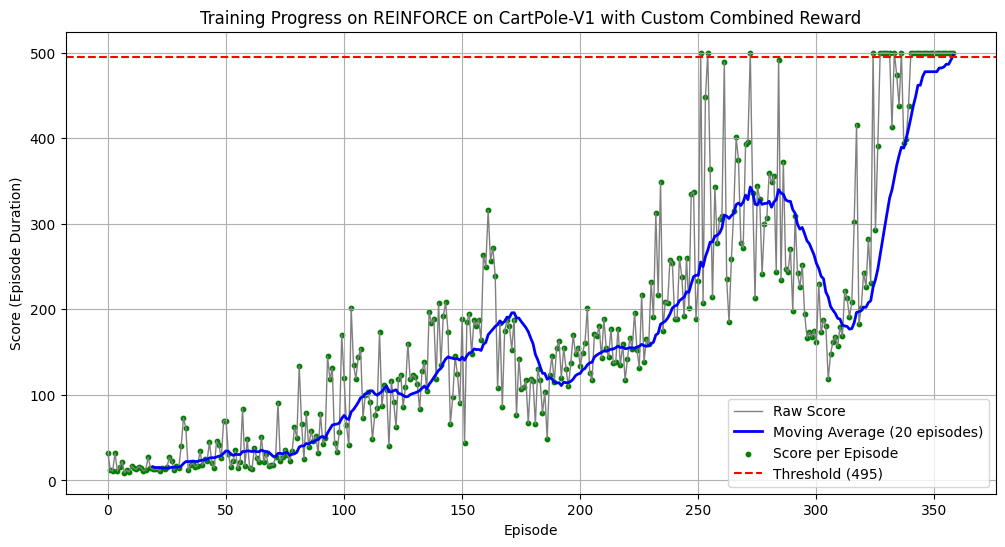

[500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 449.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 466.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0]
count    100.000000
mean     499.150000
std        6.100795
min      449.000000
25%      500.000000
50%      500.000000
75%      500.000000
max      500.000000
Name: score, dtype: float64
success
True     98
False     2
Name: count, dtype: int64


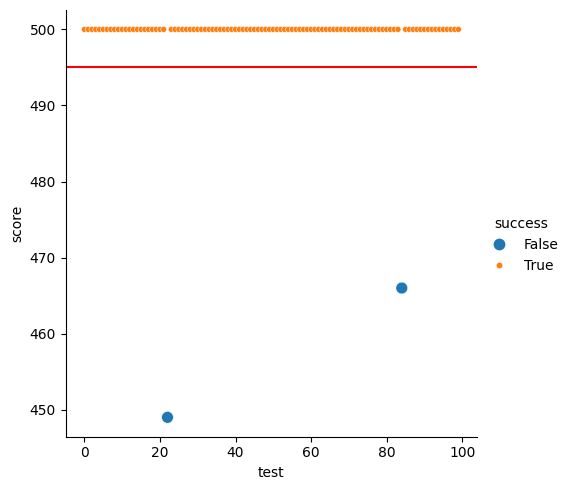

/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:593: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` i

[200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0]
Test Scores Summary:
count    100.0
mean     200.0
std        0.0
min      200.0
25%      200.0
50%      200.0
75%      200.0
max      200.0
Name: Score, dtype: float64
Success Count (Score >= 195):
Success
True    100
Name: count, dtype: int64


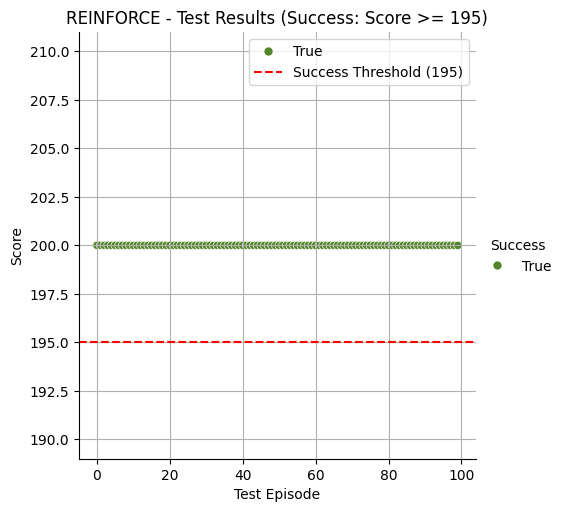

In [2]:
# Import necessary libraries
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import gym, random
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns


# Set the random seed for reproducibility
seed = 3
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

# Create the environment
env = gym.make('CartPole-v1')
env.seed(seed)

# Get state and action dimensions
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

# Get thresholds from environment constraints
theta_threshold = (env.observation_space.high[2]) / 2 - 0.001  # Pole angle
x_threshold = env.observation_space.high[0]  # Cart position

# Define the policy network
class PolicyNetwork(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_size=128):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, action_dim)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        probs = self.softmax(x)
        return probs

# Instantiate the policy network
policy_net = PolicyNetwork(state_dim, action_dim, hidden_size=128)

# Set the optimizer
learning_rate = 0.003
optimizer = optim.Adam(policy_net.parameters(), lr=learning_rate)

# Training parameters
gamma = 0.95
num_episodes = 500
max_steps = 500

# For logging
episode_rewards = []

for episode in range(1, num_episodes + 1):
    env.seed(episode)
    state = env.reset()
    env.seed(episode)

    state = torch.from_numpy(state).float()
    rewards = []
    log_probs = []

    for t in range(max_steps):
        # Get action probabilities from the policy network
        probs = policy_net(state)
        # Sample an action from the probability distribution
        m = torch.distributions.Categorical(probs)
        action = m.sample()
        log_prob = m.log_prob(action)
        # Step the environment
        next_state, r, done, _ = env.step(action.item())

        # # Extract state variables
        # x = abs(next_state[0])  # Cart position (absolute value)
        # theta = abs(next_state[2])  # Pole angle (absolute value)

        # # Compute custom rewards
        # weight1=0.15
        # cart = np.exp((x_threshold - x) / x_threshold) - 0.999  # Cart position reward
        # angle = np.exp((theta_threshold - theta) / theta_threshold) - 0.999  # Pole angle reward
        # reward = (weight1 * cart) + ((1-weight1) * angle)  # Combined reward

        next_state = torch.from_numpy(next_state).float()
        # Save reward and log probability
        # rewards.append(reward)
        rewards.append(r)

        log_probs.append(log_prob)
        # Update state
        state = next_state
        if done:
            break

    # Compute the cumulative rewards (returns) for the episode
    returns = []
    G = 0
    for r in reversed(rewards):
        G = r + gamma * G
        returns.insert(0, G)
    returns = torch.tensor(returns)
    # Normalize returns for better convergence
    returns = (returns - returns.mean()) / (returns.std() + 1e-9)
    # Compute policy gradient loss
    loss = []
    for log_prob, Gt in zip(log_probs, returns):
        loss.append(-log_prob * Gt)
    loss = torch.stack(loss).sum()
    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    # Log episode reward
    episode_rewards.append(t + 1)
    # Print progress every 50 episodes
    if episode % 50 == 0:
        avg_reward = np.mean(episode_rewards[-50:])
        print(f"Episode {episode}\tAverage Reward: {avg_reward:.2f}")

    convergence_criteria = 20
    # Check for convergence
    if episode >= convergence_criteria:
        avg_reward = np.mean(episode_rewards[-convergence_criteria:])
        if avg_reward >= 495.0:
            print(f"\nEnvironment solved in {episode} episodes with average reward {avg_reward:.2f} over the last {convergence_criteria:.2f} episodes.")
            break

# Close the environment
env.close()

# Convert 'episode_rewards' to a NumPy array for easy manipulation
score_array = np.array(episode_rewards)

# Calculate a moving average with a window size of 50
def plot_train(name, score_array, window_size = 50):

    if len(score_array) >= window_size:
        moving_avg = np.convolve(score_array, np.ones(window_size) / window_size, mode='valid')
    else:
        moving_avg = score_array  # If not enough data points, use the raw scores

    # Plot the raw scores and the moving average
    plt.figure(figsize=(12, 6))
    plt.plot(score_array, color='gray', linewidth=1, label='Raw Score')
    plt.plot(range(window_size - 1, len(score_array)), moving_avg, color='blue', linewidth=2, label=f'Moving Average ({window_size} episodes)')
    plt.scatter(range(len(score_array)), score_array, color='green', s=10, label='Score per Episode')
    plt.axhline(y=495, color='red', linestyle='--', label='Threshold (495)')

    # Labels and title
    plt.xlabel('Episode')
    plt.ylabel('Score (Episode Duration)')
    plt.title('Training Progress on %s with Custom Combined Reward'%(name))
    plt.legend()
    plt.grid(True)
    plt.show()

plot_train('REINFORCE on CartPole-V1', score_array, 20)


# Function to sample action based on the trained policy
def test_policy_sample(state, policy_net):
    state_tensor = torch.FloatTensor(state).unsqueeze(0)
    with torch.no_grad():
        action_probs = policy_net(state_tensor)
        dist = torch.distributions.Categorical(action_probs)
        action = dist.sample().item()
    return action

# Function to test the agent's performance in one episode
def test_agent_base_rl(seed, print_reward=False):
    env = gym.make('CartPole-v0')
    env.seed(seed)
    state = env.reset()
    env.seed(seed)

    rewards = []

    for t in range(200):
        action = test_policy_sample(state, policy_net)
        state, reward, terminated, truncated = env.step(action)
        done = terminated or truncated
        rewards.append(reward)
        if done:
            total_reward = sum(rewards)
            if print_reward:
                print(f"Episode {seed}, Total Reward: {total_reward}")
            return total_reward
    env.close()

# Function to test the agent across multiple episodes and visualize the results
def plot_test_results_base_rl(method='Base RL', total_tests=100):
    seed = 3
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

    test_scores = []
    for i in range(total_tests):
        test_scores.append(test_agent_base_rl(i, print_reward=False))

    print(test_scores)
    # Print summary statistics
    print("Test Scores Summary:")
    test_df = pd.DataFrame({'Test': range(total_tests), 'Score': test_scores})
    test_df['Success'] = test_df['Score'] >= 195
    print(test_df['Score'].describe())

    # Count successes
    success_count = test_df['Success'].value_counts()
    print("Success Count (Score >= 195):")
    print(success_count)

    # Visualization
    colors = {True: "#54852A", False: "#E33079"}
    sns.relplot(data=test_df, x="Test", y="Score", hue="Success", palette=colors)
    plt.axhline(y=195, color='red', linestyle='--', label='Success Threshold (195)')
    plt.title(f"{method} - Test Results (Success: Score >= 195)")
    plt.xlabel("Test Episode")
    plt.ylabel("Score")
    plt.legend()
    plt.grid(True)
    plt.show()

# seed2, weight0.14, epoch169, mu199.73, success99%
# seed3, weight0.14, epoch166, mu200, success100% - 199.796000, 498
# seed17, weigh0.14, epoch186, mu200, success100 - 200, 100
## seed3, weight0.15, epoch144, mu200, success100% - 199.396000, 496
## seed3, weight0.155, epoch192, mu200, success100% - 199.954000, 499




# import pandas as pd
# import seaborn as sns

def test_agent_500(i, print_reward=False):
    env = gym.make('CartPole-v1')
    env.seed(seed)
    state = env.reset()
    env.seed(seed)

    rewards = []

    for t in range(500):
        action = test_policy_sample(state, policy_net)
        state, reward, terminated, truncated = env.step(action)
        done = terminated or truncated
        rewards.append(reward)
        if done:
            total_reward = sum(rewards)
            if print_reward:
                print(f"Episode {seed}, Total Reward: {total_reward}")
            return total_reward
    env.close()


def plot_test_results_500(total=100):
    seed = 3
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

    test_scores = []
    for i in range(total):
        test_scores.append(test_agent_500(i, print_reward=False))

    print(test_scores)

    test_df= pd.DataFrame({'test':range(total), 'score':test_scores})
    test_df['success'] = test_df['score'].apply(lambda x: x>=495)
    print(test_df['score'].describe())
    c = test_df['success'].value_counts()
    print(c)
    # ax = sns.barplot(c)
    # ax.bar_label(ax.containers[0], fontsize=10);
    # plt.show()
    sns.relplot(data=test_df, x="test", y="score", hue="success", size="success")
    plt.axhline(y=495, color='r', linestyle='-')

    plt.show()

plot_test_results_500(total=100)

# Run the testing and plotting function
plot_test_results_base_rl(method="REINFORCE", total_tests=100)

/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:593: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` i

[200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0

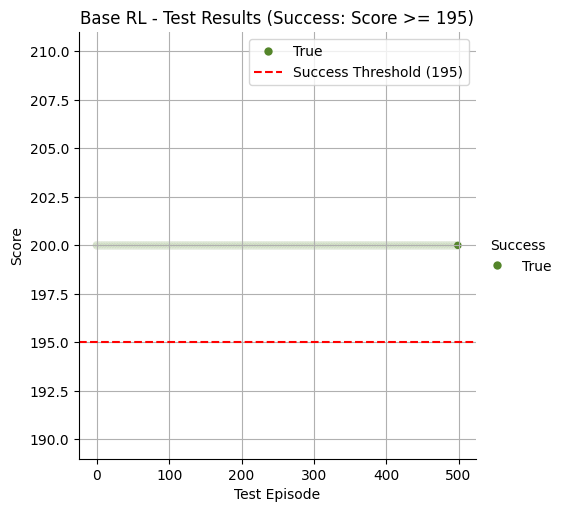

In [15]:
plot_test_results_base_rl(method="Base RL", total_tests=500)

# Replay buffer + CR

In [17]:
class replayBuffer:
    def __init__(self, buffer_size: int):
        self.buffer_size = buffer_size
        self.buffer = []

    def add(self, item):
        if len(self.buffer) == self.buffer_size:
            self.buffer.pop(0)
        self.buffer.append(item)

    def sample(self, batch_size):
        items = random.sample(self.buffer, batch_size)
        states   = [i[0] for i in items]
        actions  = [i[1] for i in items]
        rewards  = [i[2] for i in items]
        n_states = [i[3] for i in items]
        dones    = [i[4] for i in items]
        return states, actions, rewards, n_states, dones

    def length(self):
        return len(self.buffer)

buffer = replayBuffer(20000)


# Import necessary libraries
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import gym, random
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns


# Set the random seed for reproducibility
seed = 3
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

# Create the environment
env = gym.make('CartPole-v0')
env.seed(seed)

# Get state and action dimensions
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

# Get thresholds from environment constraints
theta_threshold = (env.observation_space.high[2]) / 2 - 0.001  # Pole angle
x_threshold = env.observation_space.high[0]  # Cart position

# Define the policy network
class PolicyNetwork(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_size=128):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, action_dim)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        probs = self.softmax(x)
        return probs

# Instantiate the policy network
policy_net = PolicyNetwork(state_dim, action_dim, hidden_size=128)

# Set the optimizer
learning_rate = 0.003
optimizer = optim.Adam(policy_net.parameters(), lr=learning_rate)

# Training parameters
gamma = 0.95
num_episodes = 500
max_steps = 200
batch_size = 25

# For logging
episode_rewards = []

for episode in range(1, num_episodes + 1):
    env.seed(episode)
    state = env.reset()
    env.seed(episode)

    state = torch.from_numpy(state).float()
    rewards = []
    log_probs = []

    cum_reward = 0
    for t in range(max_steps):
        # Get action probabilities from the policy network
        probs = policy_net(state)
        # Sample an action from the probability distribution
        m = torch.distributions.Categorical(probs)
        action = m.sample()
        log_prob = m.log_prob(action)
        # Step the environment
        action = action.item()
        next_state, r, done, trunc = env.step(action)

        # Extract state variables
        x = abs(next_state[0])  # Cart position (absolute value)
        theta = abs(next_state[2])  # Pole angle (absolute value)

        # Compute custom rewards
        weight1=0.15
        cart = np.exp((x_threshold - x) / x_threshold) - 0.999  # Cart position reward
        angle = np.exp((theta_threshold - theta) / theta_threshold) - 0.999  # Pole angle reward
        reward = (weight1 * cart) + ((1-weight1) * angle)  # Combined reward

        next_state = torch.from_numpy(next_state).float()
        # Save reward and log probability
        rewards.append(reward)
        log_probs.append(log_prob)

        buffer.add([state.tolist(), action, reward, next_state.tolist(), float(done)])

        cum_reward += r

        if buffer.length() >= batch_size:
            states, actions, rewards, n_states, dones = buffer.sample(batch_size)
            # Compute the cumulative rewards (returns) for the episode
            returns = []
            G = 0
            for r in reversed(rewards):
                G = r + gamma * G
                returns.insert(0, G)
            returns = torch.tensor(returns)
            # Normalize returns for better convergence
            returns = (returns - returns.mean()) / (returns.std() + 1e-9)
            # Compute policy gradient loss
            loss = []
            for log_prob, Gt in zip(log_probs, returns):
                loss.append(-log_prob * Gt)
            loss = torch.stack(loss).sum()
            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Update state
        state = next_state
        if done:
            break


    # Log episode reward
    episode_rewards.append(t + 1)
    # Print progress every 50 episodes
    if episode % 50 == 0:
        avg_reward = np.mean(episode_rewards[-50:])
        print(f"Episode {episode}\tAverage Reward: {avg_reward:.2f}")

    convergence_criteria = 30
    # Check for convergence
    if episode >= convergence_criteria:
        avg_reward = np.mean(episode_rewards[-convergence_criteria:])
        if avg_reward >= 195.0:
            print(f"\nEnvironment solved in {episode} episodes with average reward {avg_reward:.2f} over the last {convergence_criteria:.2f} episodes.")
            break

# Close the environment
env.close()

# Calculate a moving average with a window size of 50
def plot_train(name, score_array, window_size = 50):

    if len(score_array) >= window_size:
        moving_avg = np.convolve(score_array, np.ones(window_size) / window_size, mode='valid')
    else:
        moving_avg = score_array  # If not enough data points, use the raw scores

    # Plot the raw scores and the moving average
    plt.figure(figsize=(12, 6))
    plt.plot(score_array, color='gray', linewidth=1, label='Raw Score')
    plt.plot(range(window_size - 1, len(score_array)), moving_avg, color='blue', linewidth=2, label=f'Moving Average ({window_size} episodes)')
    plt.scatter(range(len(score_array)), score_array, color='green', s=10, label='Score per Episode')
    plt.axhline(y=195, color='red', linestyle='--', label='Threshold (195)')

    # Labels and title
    plt.xlabel('Episode')
    plt.ylabel('Score (Episode Duration)')
    plt.title('Training Progress on %s with Custom Combined Reward'%(name))
    plt.legend()
    plt.grid(True)
    plt.show()

# # Convert 'episode_rewards' to a NumPy array for easy manipulation
score_array = np.array(episode_rewards)

plot_train('REINFORCE on CartPole-V0', score_array, 20)


# Function to sample action based on the trained policy
def test_policy_sample(state, policy_net):
    state_tensor = torch.FloatTensor(state).unsqueeze(0)
    with torch.no_grad():
        action_probs = policy_net(state_tensor)
        dist = torch.distributions.Categorical(action_probs)
        action = dist.sample().item()
    return action

# Function to test the agent's performance in one episode
def test_agent_base_rl(seed, print_reward=False):
    env = gym.make('CartPole-v0')
    env.seed(seed)
    state = env.reset()
    env.seed(seed)

    rewards = []

    for t in range(200):
        action = test_policy_sample(state, policy_net)
        state, reward, terminated, truncated = env.step(action)
        done = terminated or truncated
        rewards.append(reward)
        if done:
            total_reward = sum(rewards)
            if print_reward:
                print(f"Episode {seed}, Total Reward: {total_reward}")
            return total_reward
    env.close()

# Function to test the agent across multiple episodes and visualize the results
def plot_test_results_base_rl(method='Base RL', total_tests=100):
    seed = 3
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

    test_scores = []
    for i in range(total_tests):
        test_scores.append(test_agent_base_rl(i, print_reward=False))

    # Print summary statistics
    print("Test Scores Summary:")
    test_df = pd.DataFrame({'Test': range(total_tests), 'Score': test_scores})
    test_df['Success'] = test_df['Score'] >= 195
    print(test_df['Score'].describe())

    # Count successes
    success_count = test_df['Success'].value_counts()
    print("Success Count (Score >= 195):")
    print(success_count)

    # Visualization
    colors = {True: "#54852A", False: "#E33079"}
    sns.relplot(data=test_df, x="Test", y="Score", hue="Success", palette=colors)
    plt.axhline(y=195, color='red', linestyle='--', label='Success Threshold (195)')
    plt.title(f"{method} - Test Results (Success: Score >= 195)")
    plt.xlabel("Test Episode")
    plt.ylabel("Score")
    plt.legend()
    plt.grid(True)
    plt.show()

# Run the testing and plotting function
plot_test_results_base_rl(method="REINFORCE", total_tests=100)

reward_records = []


/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:593: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` i

RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.

In [21]:
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.distributions import Categorical

# Define the policy network (simple MLP)
class PolicyNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, action_dim)

    def forward(self, state):
        x = torch.relu(self.fc1(state))
        x = torch.relu(self.fc2(x))
        action_probs = torch.softmax(self.fc3(x), dim=-1)
        return action_probs

# Define the Replay Buffer
class ReplayBuffer:
    def __init__(self, buffer_size):
        self.buffer_size = buffer_size
        self.buffer = []
        self.ptr = 0

    def store(self, state, action, reward, next_state):
        # Store experience in the buffer
        if len(self.buffer) < self.buffer_size:
            self.buffer.append((state, action, reward, next_state))
        else:
            self.buffer[self.ptr] = (state, action, reward, next_state)
            self.ptr = (self.ptr + 1) % self.buffer_size

    def sample(self, batch_size):
        # Sample a batch of experiences from the buffer
        indices = np.random.choice(len(self.buffer), batch_size, replace=False)
        batch = [self.buffer[idx] for idx in indices]
        states, actions, rewards, next_states = zip(*batch)
        return torch.stack(states), torch.tensor(actions), torch.tensor(rewards, dtype=torch.float32)

# Set up the environment
env = gym.make('CartPole-v0')
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

# Initialize the policy network, optimizer, and replay buffer
policy = PolicyNetwork(state_dim, action_dim)
optimizer = optim.Adam(policy.parameters(), lr=1e-3)
replay_buffer = ReplayBuffer(buffer_size=1000)

# Hyperparameters
batch_size = 32
gamma = 0.99  # Discount factor
episodes = 1000
max_timesteps = 500

# REINFORCE with Experience Replay
for episode in range(episodes):
    state = env.reset()
    episode_rewards = []
    states, actions, rewards = [], [], []

    for t in range(max_timesteps):
        state_tensor = torch.tensor(state, dtype=torch.float32)

        # Get action probabilities from the policy network
        action_probs = policy(state_tensor)

        # Sample action from the probability distribution
        dist = Categorical(action_probs)
        action = dist.sample()

        # Take the action and observe the next state and reward
        next_state, reward, done, _ = env.step(action.item())

        # Store the experience in the buffer
        replay_buffer.store(state, action.item(), reward, next_state)

        # Append to episode's list of experiences
        states.append(state_tensor)
        actions.append(action.item())
        rewards.append(reward)

        state = next_state
        episode_rewards.append(reward)

        if done:
            break

    # Sample a batch from the replay buffer to update the policy
    if len(replay_buffer.buffer) > batch_size:
        batch_states, batch_actions, batch_rewards = replay_buffer.sample(batch_size)

        # Compute the cumulative discounted rewards (returns)
        returns = []
        G = 0
        for reward in reversed(batch_rewards.numpy()):
            G = reward + gamma * G
            returns.insert(0, G)
        returns = torch.tensor(returns)

        # Compute the policy loss using the REINFORCE objective
        optimizer.zero_grad()
        log_probs = []
        for state, action in zip(batch_states, batch_actions):
            action_probs = policy(state)
            dist = Categorical(action_probs)
            log_probs.append(dist.log_prob(action))
        log_probs = torch.stack(log_probs)

        # Calculate the loss: -log(prob) * (return - value)
        loss = -log_probs * (returns - returns.mean())
        loss = loss.mean()

        # Update the policy network
        loss.backward()
        optimizer.step()

    # Print the episode reward for monitoring
    total_reward = sum(episode_rewards)
    print(f"Episode {episode + 1}: Total Reward: {total_reward}")


Episode 1: Total Reward: 14.0
Episode 2: Total Reward: 14.0


TypeError: expected Tensor as element 0 in argument 0, but got numpy.ndarray